# American Census

In [44]:
import numpy as np
import pandas as pd
import copy as copy
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import ShuffleSplit, GridSearchCV, cross_val_score, GroupKFold, StratifiedKFold, KFold,cross_validate, train_test_split

import matplotlib.pyplot as plt

## Global config

In [45]:
# Data config
path_to_csv = "adult.csv"

## Load data

In [46]:
pandas_X_train = pd.read_csv("X_train.csv")
pandas_y_train = pd.read_csv("y_train.csv")

pandas_X_test = pd.read_csv("X_test.csv")

## Helpers

In [47]:
X_train = pandas_X_train.to_numpy(copy=True)
y_train = pandas_y_train.to_numpy(copy=True)

X_test = pandas_X_test.to_numpy(copy=True)

## Data exploration

### Question 1

In [48]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
unique_array = np.asarray((unique_elements, counts_elements))
print(unique_array)
print("From above we can derive that there are an unequal number of samples belonging to each class.")
print("Class distribution for salary <50.000$: ", np.round(counts_elements[0]/counts_elements.sum()*100, 2),"%")
print("Class distribution for salary >50.000$: ", np.round(counts_elements[1]/counts_elements.sum()*100, 2),"%")

[[    0     1]
 [12360  3920]]
From above we can derive that there are an unequal number of samples belonging to each class.
Class distribution for salary <50.000$:  75.92 %
Class distribution for salary >50.000$:  24.08 %


### Question 2

In [49]:
exteded_data = np.c_[X_train, y_train]

num_men = np.where((exteded_data[:, 9] == " Male"))[0].size
num_female = np.where((exteded_data[:, 9] == " Female"))[0].size
females_under_50 = np.where((exteded_data[:, 9] == " Female") & (exteded_data[:, 11] == 0))[0].size
females_over_50 = np.where((exteded_data[:, 9] == " Female") & (exteded_data[:, 11] == 1))[0].size
men_under_50 = np.where((exteded_data[:, 9] == " Male") & (exteded_data[:, 11] == 0))[0].size
men_over_50 = np.where((exteded_data[:, 9] == " Male") & (exteded_data[:, 11] == 1))[0].size

print("Based on training data: Men >$50k: ", round((men_over_50/num_men) * 100, 2) , "%, Women >$50k: ", round(females_over_50/num_female * 100, 2), "%.")
print()
print("Distribution of races:")
unique_races, counts_races = np.unique(X_train[:, 8], return_counts=True)
zipped = zip(unique_races, counts_races)
print(list(zipped))
print()
print("The trained model will be highly biased towards the white race! Thus, race is also not quite a good paramter. The white race is found accross",
     round(counts_races[4] / X_train.shape[0] * 100, 2), "% of the training data!")

# Removal of feature is done below (Data Preparation - Q1)

Based on training data: Men >$50k:  30.51 %, Women >$50k:  11.12 %.

Distribution of races:
[(' Amer-Indian-Eskimo', 146), (' Asian-Pac-Islander', 506), (' Black', 1537), (' Other', 138), (' White', 13953)]

The trained model will be highly biased towards the white race! Thus, race is also not quite a good paramter. The white race is found accross 85.71 % of the training data!


## Data preparations

### Question 1

###### Training set

In [50]:
nan_values = np.where(X_train != X_train)
print(np.unique(nan_values).shape[0], "rows with missing values -> Can't remove 1576 rows since it will affect the training set") 

# Make deep copies
pandas_X_train_copy = copy.deepcopy(pandas_X_train)

# Back-ups
X_train_backup = copy.deepcopy(X_train)
pandas_X_train_backup = copy.deepcopy(pandas_X_train)

# Replace missing numerical values with the median of the column
# Replace missing string values with the most frequent value in the column
pandas_X_train_copy.fillna(pandas_X_train_copy.mean(), inplace=True)
pandas_X_train_copy.fillna(pandas_X_train_copy.mode(numeric_only=False).iloc[0], inplace=True)

pandas_X_train_copy.drop(["race", "sex"], inplace=True, axis=1) # Remove race & sex from the training dataset
X_train = pandas_X_train_copy.to_numpy(copy=True)

# Update values of pandas_X_train and X_train
pandas_X_train = copy.deepcopy(pandas_X_train_copy)
X_train = pandas_X_train_copy.to_numpy(copy=True)

1576 rows with missing values -> Can't remove 1576 rows since it will affect the training set


###### Test set

In [51]:
# Replace values for test set
pandas_X_test.fillna(pandas_X_test.mean(), inplace=True)
pandas_X_test.fillna(pandas_X_test.mode(numeric_only=False).iloc[0], inplace=True)

# Drop race & sex from test set
pandas_X_test.drop(["race", "sex"], inplace=True, axis=1)

### Questions 2 and 3

###### Training set

In [52]:
# Additional preprocessing needs to be done: every non-numerical column has a space before the value <_space_*value*>
pandas_X_train.workclass = pandas_X_train.workclass.str.strip()
pandas_X_train.education = pandas_X_train.education.str.strip()
pandas_X_train["marital-status"] = pandas_X_train["marital-status"].str.strip()
pandas_X_train.occupation = pandas_X_train.occupation.str.strip()
pandas_X_train.relationship = pandas_X_train.relationship.str.strip()
pandas_X_train["native-country"] = pandas_X_train["native-country"].str.strip()

###### Test set

In [53]:
# The additional preprocessing, done for the test set
pandas_X_test.workclass = pandas_X_test.workclass.str.strip()
pandas_X_test.education = pandas_X_test.education.str.strip()
pandas_X_test["marital-status"] = pandas_X_test["marital-status"].str.strip()
pandas_X_test.occupation = pandas_X_test.occupation.str.strip()
pandas_X_test.relationship = pandas_X_test.relationship.str.strip()
pandas_X_test["native-country"] = pandas_X_test["native-country"].str.strip()

###### Training set

In [54]:
# Replacing categories:
# This process decreases the computational costs and prevents for potential overfitting

# Categorically bin the countries in continents
pandas_X_train['native-country'].replace(['United-States', 'Canada'], 'North-America', inplace=True)
pandas_X_train['native-country'].replace(['Peru', 'Outlying-US(Guam-USVI-etc)', 'Trinadad&Tobago', 'Jamaica', 'Haiti', 'Nicaragua', 'Dominican-Republic', 'Puerto-Rico', 'Columbia', 'Honduras', 'South', 'Cuba', 'Mexico', 'Ecuador', 'El-Salvador', 'Guatemala'], 'South-America', inplace=True)
pandas_X_train['native-country'].replace(['Yugoslavia' , 'Ireland', 'Scotland', 'Germany', 'Poland', 'Hungary', 'England','France', 'Greece', 'Italy', 'Portugal'], 'Europe', inplace=True)
pandas_X_train['native-country'].replace(['Japan', 'China', 'Taiwan', 'Hong'], 'Asia', inplace=True)
pandas_X_train['native-country'].replace(['India', 'Iran', ], 'Middle-East', inplace=True)
pandas_X_train['native-country'].replace(['Vietnam', 'Philippines', 'Cambodia',  'Laos', 'Thailand'], 'East-Asia', inplace=True)

# Keep only not_married, married and separated
pandas_X_train['marital-status'].replace('Never-married', 'Not_married', inplace=True)
pandas_X_train['marital-status'].replace('Married-AF-spouse', 'Married', inplace=True)
pandas_X_train['marital-status'].replace('Married-civ-spouse', 'Married', inplace=True)
pandas_X_train['marital-status'].replace('Married-spouse-absent', 'Married', inplace=True)
pandas_X_train['marital-status'].replace('Divorced', 'Separated',inplace=True)

# Keep only 'High_school' 'College' 'Academic' 'Masters' 'Bachelors' 'Primary' 'Doctorate' 'Secondary'
pandas_X_train['education'].replace('Preschool', 'Primary', inplace=True)
pandas_X_train['education'].replace('1st-4th', 'Primary', inplace=True)
pandas_X_train['education'].replace('5th-6th', 'Primary', inplace=True)
pandas_X_train['education'].replace('7th-8th', 'Primary', inplace=True)
pandas_X_train['education'].replace('9th', 'Primary', inplace=True)
pandas_X_train['education'].replace('10th', 'Primary', inplace=True)
pandas_X_train['education'].replace('11th', 'Secondary', inplace=True)
pandas_X_train['education'].replace('12th', 'Secondary', inplace=True)
pandas_X_train['education'].replace('HS-grad', 'Secondary', inplace=True)
pandas_X_train['education'].replace('Some-college', 'College', inplace=True)
pandas_X_train['education'].replace('Assoc-acdm', 'Academic', inplace=True)
pandas_X_train['education'].replace('Assoc-voc', 'Academic', inplace=True)
pandas_X_train['education'].replace('Prof-school', 'Doctorate', inplace=True)

# Never-worked -> only in train
pandas_X_train['workclass'].replace('Never-worked', 'Without-pay', inplace=True)

X_train = pandas_X_train.to_numpy(copy=True)

###### Test set

In [55]:
# Replacing categories, for the test set:

# Categorically bin the countries in continents
pandas_X_test['native-country'].replace(['United-States', 'Canada'], 'North-America', inplace=True)
pandas_X_test['native-country'].replace(['Peru', 'Outlying-US(Guam-USVI-etc)', 'Trinadad&Tobago', 'Jamaica', 'Haiti', 'Nicaragua', 'Dominican-Republic', 'Puerto-Rico', 'Columbia', 'Honduras', 'South', 'Cuba', 'Mexico', 'Ecuador', 'El-Salvador', 'Guatemala'], 'South-America', inplace=True)
pandas_X_test['native-country'].replace(['Yugoslavia' , 'Ireland', 'Scotland', 'Germany', 'Poland', 'Hungary', 'England','France', 'Greece', 'Italy', 'Portugal', 'Holand-Netherlands'], 'Europe', inplace=True)
pandas_X_test['native-country'].replace(['Japan', 'China', 'Taiwan', 'Hong'], 'Asia', inplace=True)
pandas_X_test['native-country'].replace(['India', 'Iran', ], 'Middle-East', inplace=True)
pandas_X_test['native-country'].replace(['Vietnam', 'Philippines', 'Cambodia',  'Laos', 'Thailand'], 'East-Asia', inplace=True)

# Keep only not_married, married and separated
pandas_X_test['marital-status'].replace('Never-married', 'Not_married', inplace=True)
pandas_X_test['marital-status'].replace('Married-AF-spouse', 'Married', inplace=True)
pandas_X_test['marital-status'].replace('Married-civ-spouse', 'Married', inplace=True)
pandas_X_test['marital-status'].replace('Married-spouse-absent', 'Married', inplace=True)
pandas_X_test['marital-status'].replace('Divorced', 'Separated',inplace=True)

# Keep only 'High_school' 'College' 'Academic' 'Masters' 'Bachelors' 'Primary' 'Doctorate' 'Secondary'
pandas_X_test['education'].replace('Preschool', 'Primary', inplace=True)
pandas_X_test['education'].replace('1st-4th', 'Primary', inplace=True)
pandas_X_test['education'].replace('5th-6th', 'Primary', inplace=True)
pandas_X_test['education'].replace('7th-8th', 'Primary', inplace=True)
pandas_X_test['education'].replace('9th', 'Primary', inplace=True)
pandas_X_test['education'].replace('10th', 'Primary', inplace=True)
pandas_X_test['education'].replace('11th', 'Secondary', inplace=True)
pandas_X_test['education'].replace('12th', 'Secondary', inplace=True)
pandas_X_test['education'].replace('HS-grad', 'Secondary', inplace=True)
pandas_X_test['education'].replace('Some-college', 'College', inplace=True)
pandas_X_test['education'].replace('Assoc-acdm', 'Academic', inplace=True)
pandas_X_test['education'].replace('Assoc-voc', 'Academic', inplace=True)
pandas_X_test['education'].replace('Prof-school', 'Doctorate', inplace=True)

X_test = pandas_X_test.to_numpy(copy=True)

### Question 2

###### Training set

In [56]:
# classes:
workclass = np.sort(pandas_X_train.workclass.unique())
education = np.sort(pandas_X_train.education.unique())
marital_status = np.sort(pandas_X_train["marital-status"].unique())
occupation = np.sort(pandas_X_train.occupation.unique())
relationship = np.sort(pandas_X_train.relationship.unique())
native_country = np.sort(pandas_X_train["native-country"].unique())

# Using OneHotEncoder: for all attributes except the first 3
encoder = preprocessing.OneHotEncoder(categories=[workclass, education, marital_status, occupation, relationship, native_country], sparse=False)
X_train_categorically_encoded = encoder.fit_transform(X_train[:, 3:])
X_train_encoded = np.c_[X_train[:, :3], X_train_categorically_encoded]

# Using get dummies
pandas_X_train_encoded = pd.get_dummies(pandas_X_train, prefix_sep='_', drop_first=True)
pandas_X_train_encoded_backup = copy.deepcopy(pandas_X_train_encoded)

###### Test set

In [57]:
# classes:
workclass = np.sort(pandas_X_test.workclass.unique())
education = np.sort(pandas_X_test.education.unique())
marital_status = np.sort(pandas_X_test["marital-status"].unique())
occupation = np.sort(pandas_X_test.occupation.unique())
relationship = np.sort(pandas_X_test.relationship.unique())
native_country = np.sort(pandas_X_test["native-country"].unique())

# Using OneHotEncoder: for all attributes except the first 3
encoder_test = preprocessing.OneHotEncoder(categories=[workclass, education, marital_status, occupation, relationship, native_country], sparse=False)
X_test_categorically_encoded = encoder_test.fit_transform(X_test[:, 3:])
X_test_encoded = np.c_[X_test[:, :3], X_test_categorically_encoded]

# Using get dummies
pandas_X_test_encoded = pd.get_dummies(pandas_X_test, prefix_sep='_', drop_first=True)
pandas_X_test_encoded_backup = copy.deepcopy(pandas_X_test_encoded)

### Question 3

###### Training set

In [58]:
# Normalization: first 3 attributes: age, education-num, hours-per-week
X_train_cat_normalized = preprocessing.normalize(pandas_X_train_encoded[["age", "education-num", "hours-per-week"]], norm="l2")
X_train_normalized = np.c_[X_train_cat_normalized, X_train_encoded[:, 3:]]

###### Test set

In [59]:
# Normalization of test set: first 3 attributes: age, education-num, hours-per-week
X_test_cat_normalized = preprocessing.normalize(pandas_X_test_encoded[["age", "education-num", "hours-per-week"]], norm="l2")
X_test_normalized = np.c_[X_test_cat_normalized, X_test_encoded[:, 3:]]

###### Making copies of the dataset

In [60]:
# This data will aid in testing and experimenting with the data
X_data_norm = copy.deepcopy(X_train_normalized)
X_data_enc = copy.deepcopy(X_train_encoded)
X_test = copy.deepcopy(X_test_normalized)
y_data = copy.deepcopy(y_train)

## Experiments

### Question 1

In [61]:
# Kfold
def k_fold_fit_evaluate(X, y, model, scoring_method, n_splits=2):
    k_fold = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    scores = cross_validate(model, X, y, scoring=scoring_method, cv=k_fold, n_jobs=-1)
    return scores["test_score"]

### Question 2

In [62]:
random_state = 42
n_splits = 10

models = {
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, random_state=random_state),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "SVM": SVC(C=10, kernel ="poly", random_state=random_state),
    "LogisticRegression": LogisticRegression(C=10, penalty="none", random_state=42)  
}

# The evaluation method
scoring_method_f1 = make_scorer(lambda prediction, true_target: f1_score(true_target, prediction, average="weighted"))

dict_kfold = dict()

for name, model in models.items():
    kf_metrics_f1 = k_fold_fit_evaluate(X_data_norm, np.ravel(y_data), model, scoring_method_f1, n_splits=n_splits)
    dict_kfold[name] = np.round(np.mean(kf_metrics_f1)*100, 2)
    
print("Number of splits for the K Folds:", n_splits)

Number of splits for the K Folds: 10


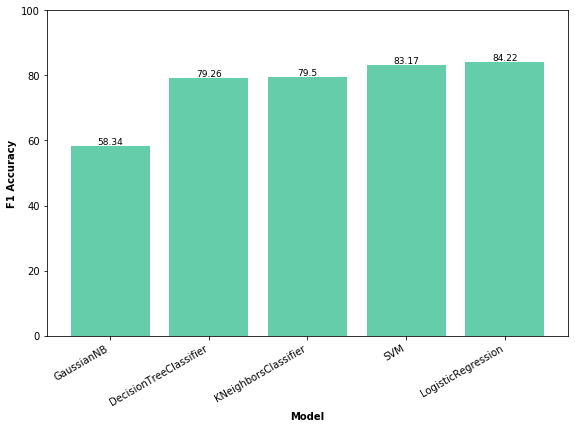

In [63]:
bar = list(dict_kfold.values())
r = np.arange(len(bar))

fig = plt.figure(figsize=(8, 6))
plt.bar(*zip(*dict_kfold.items()), color='mediumaquamarine')
plt.xlabel('Model', fontweight='bold')
plt.ylabel('F1 Accuracy', fontweight='bold')

for i in range(len(bar)):
    plt.annotate(str(bar[i]), xy=(r[i],bar[i]), ha='center', va='bottom', size=9)

fig.autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 100)
plt.show()

### Question 3

In [64]:
model_parameters = {
    "GaussianNB": {},
    "DecisionTreeClassifier": {
        'max_depth': [10, 15],
        'random_state': [random_state],
        'min_samples_leaf': [7, 8]
    },
    "KNeighborsClassifier": {
        'n_neighbors': [9, 10],
        'weights': ['uniform', 'distance']
    },
    "SVM": {
        'C': [4, 6],
        'kernel': ['linear'],
        'random_state': [random_state]
    },
    "LogisticRegression": {
        'C': [6, 8, 10],
        'penalty': ['l2', 'l1'],
        'random_state': [random_state],
        'max_iter': [1000]
    }
}

dict_models = dict()
for model_name, parameters in model_parameters.items():
    model = models[model_name]
    
    cv = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    
    grid_search = GridSearchCV(model, parameters, cv=cv.split(X_data_norm, y_data), n_jobs=-1, verbose=False, scoring=scoring_method_f1).fit(X_data_norm, np.ravel(y_data))

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    dict_models[model_name] = np.round(np.mean(best_score)*100, 2)
    
    print(model_name)
    print("- best_score =", best_score)
    print("- best parameters:")
    for k,v in best_params.items():
        print("  -", k, v)

GaussianNB
- best_score = 0.5845416036156112
- best parameters:
DecisionTreeClassifier
- best_score = 0.8241348549029712
- best parameters:
  - max_depth 10
  - min_samples_leaf 8
  - random_state 42
KNeighborsClassifier
- best_score = 0.8311237346786431
- best parameters:
  - n_neighbors 10
  - weights uniform
SVM
- best_score = 0.8417646433614168
- best parameters:
  - C 6
  - kernel linear
  - random_state 42
LogisticRegression
- best_score = 0.8425943838547456
- best parameters:
  - C 10
  - max_iter 1000
  - penalty l2
  - random_state 42


### Question 4

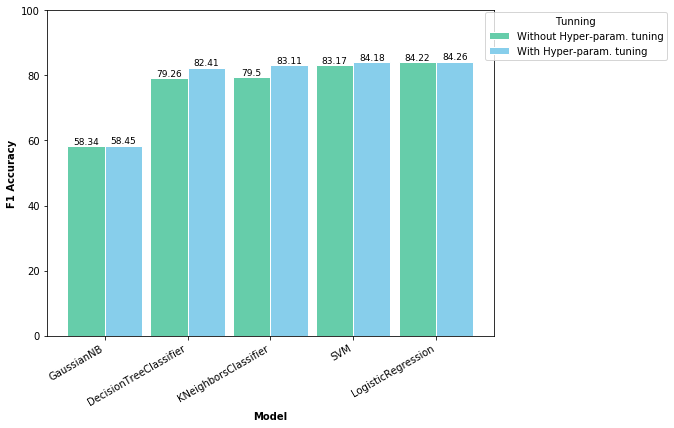

In [65]:
barWidth = 0.45
bars1 = list(dict_kfold.values())
bars2 = list(dict_models.values())

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

fig = plt.figure(figsize=(10, 6))
plt.bar(r1, bars1, color='mediumaquamarine', width=barWidth, edgecolor='white', label='Without Hyper-param. tuning')
plt.bar(r2, bars2, color='skyblue', width=barWidth, edgecolor='white', label='With Hyper-param. tuning')

plt.xticks([r + barWidth/2 for r in range(len(bars1))], list(model_parameters.keys()))
plt.xlabel('Model', fontweight='bold')
plt.ylabel('F1 Accuracy', fontweight='bold')

for i in range(len(bars1)):
    plt.annotate(str(bars1[i]), xy=(r1[i],bars1[i]), ha='center', va='bottom', size=9)
    plt.annotate(str(bars2[i]), xy=(r2[i],bars2[i]), ha='center', va='bottom', size=9)

plt.legend(bbox_to_anchor=(1.4, 1.01), loc='upper right', title='Tunning')
fig.autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 100)    
plt.show()

### Question 5

In [66]:
classifier = LogisticRegression(C=10, penalty='l2', random_state=42, max_iter=1000).fit(X_data_norm, y_data.ravel())
prediction = classifier.predict(X_test)
pd.DataFrame(prediction).to_csv("GROUP_classes_problem_census.txt", index=False, header=False)